In [151]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

def echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    x: 1d array-like, freq
    y: 1d array-like, power spectrum
    period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    fmin = 0.0 if fmin<0. else fmin - (fmin % period)

    # define plotting elements
    resolution = np.median(np.diff(x))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/period) 
    # number of point per stack
    n_element = int(period/resolution) 

    fstart = fmin - (fmin % period)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
    extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
    return z, extent

class Star():
    def __init__(self, nu, ps, numax, Dnu, fmin=None, fmax=None, cmap='gray_r'):
        '''
        Make interactive frequency and strectched period echelle plots. Useful for finding Dnu and DPi1.
 
        Input parameters
        ----
        nu: 1d array-like, freq
        ps: 1d array-like, power spectrum
        numax: float, frequency of maximum power
        Dnu: float, p-mode large separation (approximate value is fine)
        fmin: float, minimum frequency to be plotted
        fmax: float, maximum frequency to be plotted
        cmap: str, colormap passed to matplotlib.pyplot.ax.imshow

        Users can create an interactive plot with the following command:
        ----

        %matplotlib widget

        # initiate a star object
        star = Star(nu, ps, numax, Dnu)

        # interactive echelles
        star.plot_freq_echelle()
        
        '''
        # trim data
        fmin = numax-4*Dnu if fmin is None else fmin
        fmax = numax+4*Dnu if fmax is None else fmax
        trim = (nu > fmin) & (nu < fmax)
        self.nu = nu[trim]
        self.ps = ps[trim]
        self.numax = numax
        self.Dnu = Dnu
        
        # initialize slider values
        self.Dnu_init = self.Dnu
        self.eps_p_init = 0.5
        self.d02_init = 0.15
        self.d01_init = 0.
        self.DPi1_init = 250
        self.q_init = 0.5
        
        # get radial orders
        self.ns = np.unique(np.array(self.nu/self.Dnu, dtype=int))[1:-1]

        Theta_p = np.pi * (self.nu/self.Dnu_init- (1/2+self.eps_p_init+self.d01_init) ) 
        self.tau = 1/(self.nu*1e-6) + self.DPi1_init/np.pi * np.arctan(self.q_init / np.tan(Theta_p))
        
        # passed to echelle api
        self.freq_echelle_kwargs = {'fmin':np.min(self.nu), 'fmax':np.max(self.nu), 'echelletype': 'replicated'}
        self.period_echelle_kwargs = {'fmin':np.min(self.tau), 'fmax':np.max(self.tau), 'echelletype': 'replicated'}
        
        # passes to matplotlib api
        self.cmap = cmap
        
    def plot_freq_echelle(self):
        
        fig = plt.figure(figsize=(10,6))

        xpos, xoff = 0.16, 0.45
        ypos, yoff = 0.95, 0.04
        width = 0.33
        
        # Make a horizontal slider to control Dnu.
        slider_Dnu = Slider(
            ax=fig.add_axes([xpos, ypos, width, 0.03]),
            label='Dnu',
            valmin=self.Dnu*0.9,
            valmax=self.Dnu*1.1,
            valinit=self.Dnu_init,
            valstep=self.Dnu*0.002,
        )
        
        # Make a horizontal slider to control eps_p.
        slider_eps_p = Slider(
            ax=fig.add_axes([xpos, ypos-yoff, width, 0.03]),
            label='eps_p',
            valmin=0.0,
            valmax=1.0,
            valinit=self.eps_p_init,
            valstep=0.01,
        )
        
        # Make a horizontal slider to control d02.
        slider_d02 = Slider(
            ax=fig.add_axes([xpos, ypos-yoff*2, width, 0.03]),
            label='d02',
            valmin=0.0,
            valmax=0.3,
            valinit=self.d02_init,
            valstep=0.005,
        )
        
        # Make a horizontal slider to control d01.
        slider_d01 = Slider(
            ax=fig.add_axes([xpos+xoff, ypos, width, 0.03]),
            label='d01',
            valmin=-0.5,
            valmax=0.5,
            valinit=self.d01_init,
            valstep=0.01,
        )
        
        # Make a horizontal slider to control DPi1.
        slider_DPi1 = Slider(
            ax=fig.add_axes([xpos+xoff, ypos-yoff, width, 0.03]),
            label='DPi1',
            valmin=30,
            valmax=400,
            valinit=self.DPi1_init,
            valstep=0.5,
        )
        
        # Make a horizontal slider to control q.
        slider_q = Slider(
            ax=fig.add_axes([xpos+xoff, ypos-yoff*2, width, 0.03]),
            label='q',
            valmin=0.0,
            valmax=1.0,
            valinit=self.q_init,
            valstep=0.01,
        )

        
        # create two axes
        axes = [fig.add_axes([xpos, 0.1, width, 0.7]), fig.add_axes([xpos+xoff, 0.1, width, 0.7]) ]
        
        # fig 1: frequency echelle diagram
        z, ext = echelle(
            self.nu, 
            self.ps, 
            self.Dnu_init,
            **self.freq_echelle_kwargs
        )

        image1 = axes[0].imshow(
            z, 
            extent=ext, 
            aspect='auto', 
            interpolation='nearest', 
            cmap=self.cmap
        )
        
        axes[0].axis(ext)
        
        nu0s = [self.eps_p_init*self.Dnu_init, (self.eps_p_init+1)*self.Dnu_init]
        nu2s = [(self.eps_p_init-self.d02_init)*self.Dnu_init, (self.eps_p_init-self.d02_init+1)*self.Dnu_init, (self.eps_p_init-self.d02_init+2)*self.Dnu_init] 
        vlines0 = [axes[0].axvline(nu, color='b', linestyle='--', alpha=0.5) for nu in nu0s ]
        vlines2 = [axes[0].axvline(nu, color='g', linestyle='--', alpha=0.5) for nu in nu2s ]
        
        axes[0].set_xlabel(r"Frequency mod {:0.2f} $\mu$Hz".format(self.Dnu_init))
        axes[0].set_ylabel(r"Frequency $\mu$Hz")

        
        # fig 2: streched period echelle diagram
        z, ext = echelle(
            self.tau[::-1], 
            self.ps[::-1], 
            self.DPi1_init,
            **self.period_echelle_kwargs
        )

        image2 = axes[1].imshow(
            z, 
            extent=ext, 
            aspect='auto', 
            interpolation='nearest', 
            cmap=self.cmap
        )
        
        axes[1].axis(ext)
        axes[1].invert_yaxis()
        
        l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+self.eps_p_init)*self.Dnu_init ).argmin(axis=0)
        l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+self.eps_p_init-self.d02_init)*self.Dnu_init ).argmin(axis=0)
        hlines0 = [axes[1].axhline(tau, color='b', linestyle='--', alpha=0.5) for tau in self.tau[l0]]
        hlines2 = [axes[1].axhline(tau, color='g', linestyle='--', alpha=0.5) for tau in self.tau[l2]]

        axes[1].set_xlabel('Stretched period mod {:.1f} (s)'.format(self.DPi1_init))
        axes[1].set_ylabel('Stretched period (s)')

        # callback functions
        def update_Dnu(val):
            z, ext = echelle(
                self.nu, 
                self.ps, 
                slider_Dnu.val,
                **self.freq_echelle_kwargs
            )
            
            image1.set(array=z, extent=ext)
            axes[0].axis(ext)
            axes[0].set_xlabel(r"Frequency mod {:0.2f} ($\mu$Hz)".format(slider_Dnu.val))

            nu0s = [slider_eps_p.val*self.Dnu_init, (slider_eps_p.val+1)*slider_Dnu.val]
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu0s): vlines0[i].set_xdata([nu, nu])
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
        
            l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val)*slider_Dnu.val ).argmin(axis=0)
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l0]): hlines0[i].set_ydata([tau, tau])
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau])
            
            fig.canvas.draw_idle()
            
        def update_eps_p(val):
            nu0s = [slider_eps_p.val*self.Dnu_init, (slider_eps_p.val+1)*slider_Dnu.val]
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu0s): vlines0[i].set_xdata([nu, nu])
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
            
            l0 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val)*slider_Dnu.val ).argmin(axis=0)
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l0]): hlines0[i].set_ydata([tau, tau])
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau])
        
            fig.canvas.draw_idle()
            
        def update_d02(val):
            nu2s = [(slider_eps_p.val-slider_d02.val)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+1)*slider_Dnu.val, (slider_eps_p.val-slider_d02.val+2)*slider_Dnu.val] 
            for i, nu in enumerate(nu2s): vlines2[i].set_xdata([nu, nu])
            
            l2 = np.abs(self.nu.reshape(-1,1) - (self.ns+slider_eps_p.val-slider_d02.val)*slider_Dnu.val ).argmin(axis=0)
            for i, tau in enumerate(self.tau[l2]): hlines2[i].set_ydata([tau, tau]) 
        
            fig.canvas.draw_idle()
            
        def update_g(val):
            
            Theta_p = np.pi * (self.nu/slider_Dnu.val- (1/2+slider_eps_p.val+slider_d01.val) ) 
            self.tau = 1/(self.nu*1e-6) + slider_DPi1.val/np.pi * np.arctan(slider_q.val / np.tan(Theta_p))
            
            z, ext = echelle(
                self.tau[::-1], 
                self.ps[::-1], 
                slider_DPi1.val,
                **self.period_echelle_kwargs
            )
            
            image2.set(array=z, extent=ext)
            axes[1].axis(ext)
            axes[1].invert_yaxis()
            axes[1].set_xlabel('Stretched period mod {:.1f} (s)'.format(slider_DPi1.val))
            fig.canvas.draw_idle()
            
        # link sliders to callback functions
        slider_Dnu.on_changed(update_Dnu)
        slider_eps_p.on_changed(update_eps_p)
        slider_d02.on_changed(update_d02)
        
        slider_d01.on_changed(update_g)
        slider_DPi1.on_changed(update_g)
        slider_q.on_changed(update_g)
        
        plt.show()

# Courtney's stars

In [159]:
def get_star_info(kic):
    data = se.read_yu_power_spectra('/Volumes/silo3/yali4742/database/Spectra16000/{:0.0f}.seis'.format(kic))
    freq, power, Dnu, numax = data['freq'], data['psd'], data['dnu2'], data['numax2']
    powers = se.smoothWrapper(freq, power, Dnu/100, 'bartlett')
    return freq, power, powers, Dnu, numax

## KIC 3758458

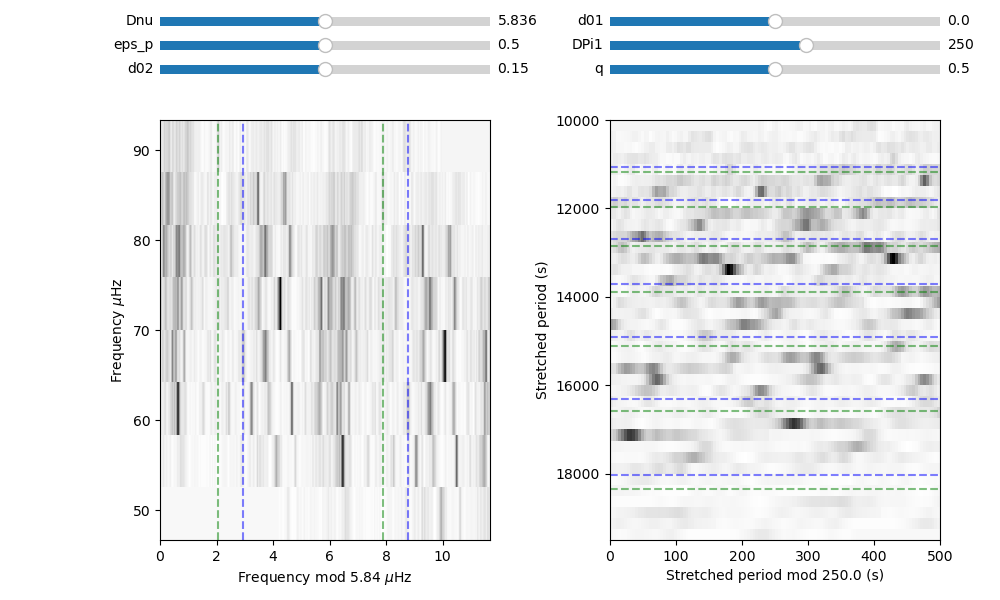

In [152]:
# grab a star's numax, Dnu, freq, powers (smoothed power)
kic = 3758458
freq, power, powers, Dnu, numax = get_star_info(kic)

# resample spectrum to have 5000 pixels
nu = np.linspace(numax-4*Dnu, numax+4*Dnu, 5000)
ps = np.interp(nu, freq, powers)

# initiate a star object
star = Star(nu, ps, numax, Dnu)

# interactive echelles
star.plot_freq_echelle()

## KIC 3747623

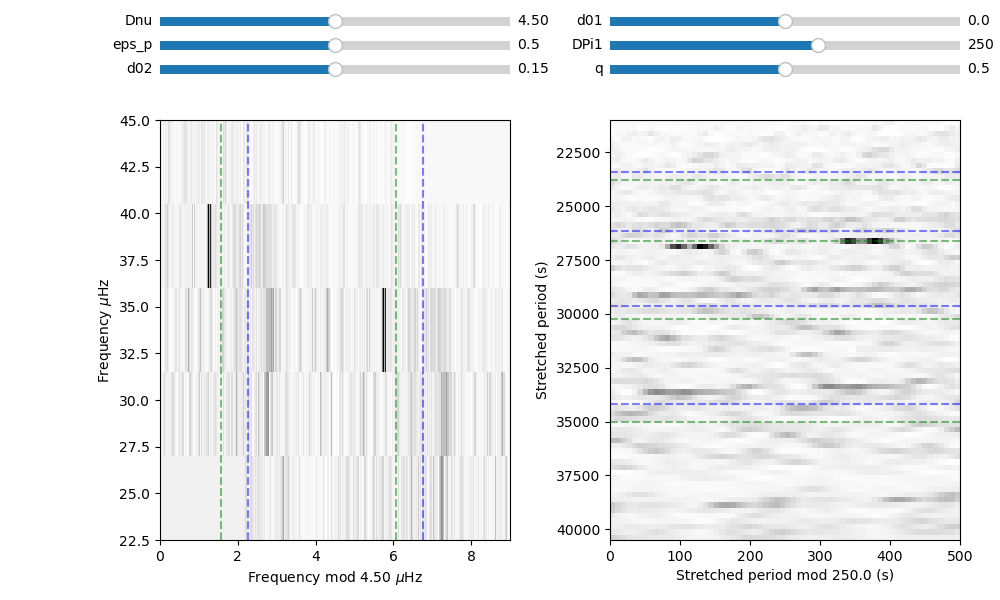

In [150]:
# grab a star's numax, Dnu, freq, powers (smoothed power)
kic = 3747623
freq, power, powers, Dnu, numax = get_star_info(kic)

Dnu = 4.5
# resample spectrum to have 5000 pixels
nu = np.linspace(numax-1*Dnu, numax+4*Dnu, 5000)
ps = np.interp(nu, freq, powers)

# initiate a star object
star = Star(nu, ps, numax, Dnu)

# interactive echelles
star.plot_freq_echelle()

# an underluminous star

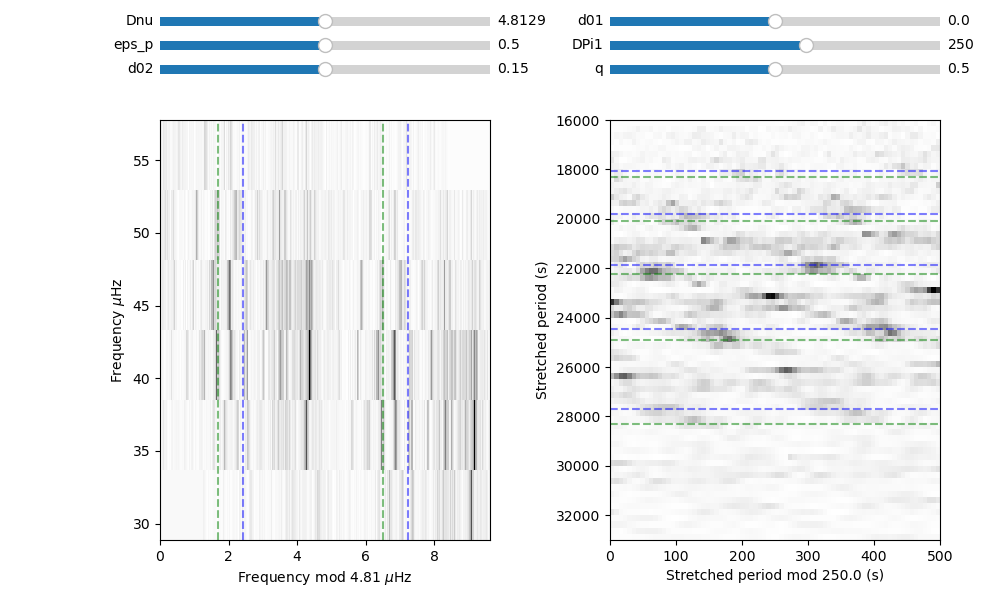

In [162]:
# grab a star's numax, Dnu, freq, powers (smoothed power)
kic = 5000307
freq, power, powers, Dnu, numax = get_star_info(kic)

# Dnu = 4.5
# resample spectrum to have 5000 pixels
nu = np.linspace(numax-2.5*Dnu, numax+4*Dnu, 5000)
ps = np.interp(nu, freq, powers)

# initiate a star object
star = Star(nu, ps, numax, Dnu)

# interactive echelles
star.plot_freq_echelle()

# Mosser's star

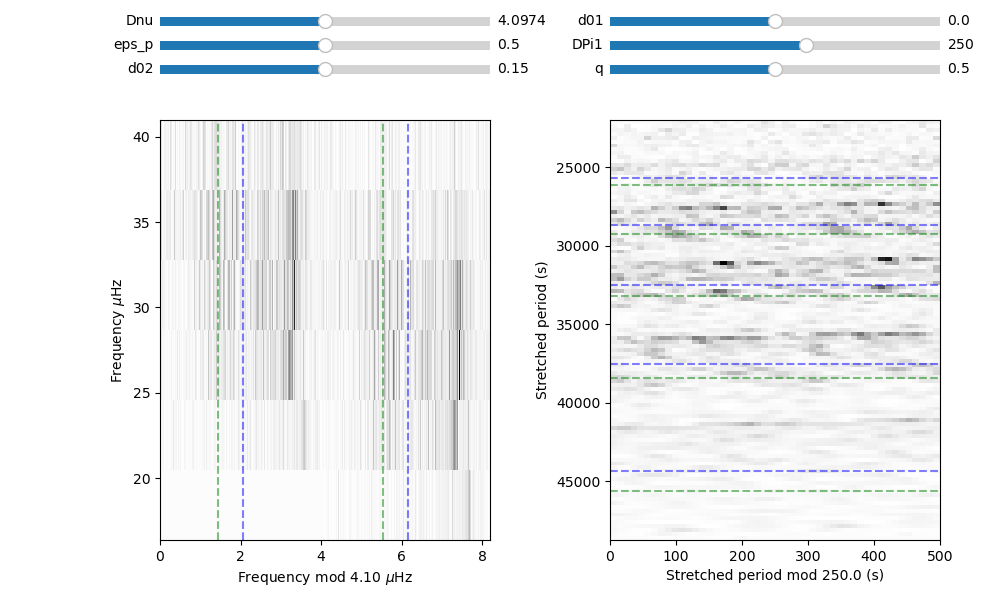

In [168]:
 
# grab a star's numax, Dnu, freq, powers (smoothed power)
kic = 7102567
freq, power, powers, Dnu, numax = get_star_info(kic)

# Dnu = 4.5
# resample spectrum to have 5000 pixels
nu = np.linspace(numax-2.5*Dnu, numax+3.5*Dnu, 5000)
ps = np.interp(nu, freq, powers)

# initiate a star object
star = Star(nu, ps, numax, Dnu)

# interactive echelles
star.plot_freq_echelle()